## ATMO Minichallenge objectives

- Predict pollutant concentrations (03 ,N02 ,PM10,PM2.5) at time D0 +1,+2,+3 from hourly measures timeseries + weather data + chemistry based forecasting models (CHIMERE).

- Both supervised regression or classification (pollution alert or not) tasks may be addressed

- you can elaborate on this notebook to derive and optimize your pipeline 

### Training set: *2015 files*

- In the data file, you have the quantity of ozone (03) recorded
hour by hour, during the whole year on several stations
distributed in Rhône-Alpes. You can specialize at a first glance to
the stations coded with *idPolair* equals
to "15013", "15018", "20017", "27002", "29426"

- In the CHIMERE file, you have the (D+1) forecasts based on chemistry models
for quantity of ozone hour by hour, during the whole year on several stations
distributed in Rhône-Alpes.

### Test set: *2016* data and CHIMERE files

### Objectives:

Your mission is to predict the hourly ozone amounts in 2016 and predict the exceedance of the $100$ threshold (pollution alert).

To do this, you can first specialize your prediction to a given day of the week, say Thursday:
- fit a method of each hour of **Thursday** based on the hours of the past 3 days on the 2015 data, and also the CHIMERE forecasts.
- then predict the Ozone value for **Thursdays** in 2016;
- fit a classification rule to detect the exceedance of threshold **100** for each hour on Thursday based on the hours of the past 3 days to the 2015 data,
and then predict whether or not there will be a pollution alert
for Thursdays in 2016.

Of course, you can use all the methods presented during the course.


Advice: for training and test, you can specialize
at a first time to the stations coded with *idPolair* equals
to "15013", "15018", "20017", "27002", "29426"


## How to read 'rds'/'Rdata' file with python:

### package to manage these files
https://github.com/ofajardo/pyreadr

### To install


- If you are using a Anaconda distribution, e.g. on your local computer, then use the `conda` way:

    `conda install -c conda-forge pyreadr`


- If you are using a jupyterhub service, e.g.  [jupyterhub.u-ga.fr](https://jupyterhub.u-ga.fr) or [google-colab](https://colab.research.google.com/), you can directly pip install it in the notebook:

    `!pip install pyreadr`
    
    

### To read
    import pyreadr

    result = pyreadr.read_r('data/Challenge_Data_O3_2015.rds')
    # if rds file
    df1 = result[None] # extract the pandas data frame for the only object available

In [1]:
# For  jupyterhub.u-ga.fr (or google-colab) users:
# you can pip install it by uncommenting the nextline
#!pip install pyreadr
import pyreadr

In [2]:
import pandas as pd
import numpy as np
import datetime
# How to display figures (change to '%matplotlib widget' for interactive plots)
%matplotlib inline

## Ozone  concentration measurements : Data reduction (checking and re-organizing)
The file named Ozone_Meas contains ozone concentration measures for a subset of 74 station among the stations of the network (identified by the idPolair code XXYYY  : Organism=XX, Station nimn=YYY). 
Note that the total number of O3 concentration measures in `Ozone_Meas` is $365\times 24 \times 74=648240$ (i.e. one year of hourly measures over 74 stations)

In [3]:
from pathlib import Path
# In which folder are the data files ?
data_folder = Path('minichallenge-data')
# Uncomment the next line if the data files .rds are in the current folder
#data_folder = Path('.')

In [4]:
# Ozone concentration time series
filename = str( data_folder / 'Challenge_Data_O3_2015.rds')
result1 = pyreadr.read_r(filename)
Ozone_Meas = result1[None]
Ozone_Meas


,Organisme,Station,Mesure,Valeur,idPolair,date
0,15,13,9,13.0,15013,2015-01-01 00
1,15,13,9,12.0,15013,2015-01-01 01
2,15,13,9,28.0,15013,2015-01-01 02
3,15,13,9,13.0,15013,2015-01-01 03
4,15,13,9,30.0,15013,2015-01-01 04
...,...,...,...,...,...,...
648235,7,58,10,NaN,7058,2015-12-31 19
648236,7,58,10,NaN,7058,2015-12-31 20
648237,7,58,10,NaN,7058,2015-12-31 21
648238,7,58,10,NaN,7058,2015-12-31 22


In [5]:
# Ozone concentration time series
filename = str( data_folder / 'Challenge_Data_O3_2015.rds')
result1 = pyreadr.read_r(filename)
Ozone_Meas = result1[None]
print('Labels of the available data :  \n\n', Ozone_Meas.columns.to_list())

# View the stations where measurements are available
print('\n\nList of measurement stations :\n\n ',pd.unique(Ozone_Meas['idPolair']))

# number of stations involved
print(" \n\n{} stations are actually measuring O3 concentration"\
      .format(pd.unique(Ozone_Meas['idPolair']).size))

# set the datetime value as the index of the time series
# (useful later on to facilitate and robustify the manipulation of the data)
Ozone_Meas.index = pd.DatetimeIndex(Ozone_Meas['date']).tz_localize('UTC')
Ozone_Meas = Ozone_Meas.drop(columns=['date'])

print('\n\nDescription of dataframe Ozone_Meas :  \n\n', Ozone_Meas)

Labels of the available data :  

 ['Organisme', 'Station', 'Mesure', 'Valeur', 'idPolair', 'date']


List of measurement stations :

  ['15013' '15017' '15018' '15031' '15038' '15043' '15045' '15048' '15049'
 '20004' '20017' '20037' '20045' '20046' '20047' '20048' '20049' '20061'
 '20062' '27002' '27003' '27004' '27005' '27007' '27010' '29421' '29423'
 '29424' '29426' '29439' '29440' '33101' '33102' '33111' '33120' '33121'
 '33201' '33202' '33211' '33212' '33220' '33302' '33305' '33414' '33233'
 '33303' '36001' '36002' '36005' '36019' '36021' '7009' '7004' '7001'
 '7051' '7032' '7045' '7013' '7016' '7049' '7017' '7014' '7054' '7012'
 '7018' '7015' '7020' '7022' '7031' '7029' '7052' '7056' '7057' '7058']
 

74 stations are actually measuring O3 concentration


Description of dataframe Ozone_Meas :  

                            Organisme  Station  Mesure  Valeur idPolair
date                                                                  
2015-01-01 00:00:00+00:00         15       13

## Ozone concentration physico_chemical predictions (CHIMERE)

The file named Ozone_Chimere contains ozone concentration predictions  for all 107 stations of the network. Note that the total number of `Ozone_Chimere` O3 concencentration forecasts is $365 \times 24 \times 107$ (i.e. one year of hourly measures over 107 stations).

In [6]:
# CHIMERE Ozone forecasts
filename = str( data_folder / 'CHIMERE_O3_2015.rds')
result2 = pyreadr.read_r(filename)
Ozone_Chimere = result2[None]
print('Labels of the available data :  \n\n', Ozone_Chimere.columns.to_list())

# View the stations where measurements are available
print('\n\n Sorted List of stations where O3 concentration is modeled :\n\n',\
      sorted(pd.to_numeric(pd.unique(Ozone_Chimere['idPolair']))))

# number of stations involved
print(" \n\n {} stations are actually predicting (D+1) O3 concentration"\
      .format(pd.unique(Ozone_Chimere['idPolair']).size))

# set the datetime value as the index of the time series
# (useful later on to facilitate and robustify the manipulation of the data)
Ozone_Chimere.index = pd.DatetimeIndex(Ozone_Chimere['date']).tz_localize('UTC')
Ozone_Chimere = Ozone_Chimere.drop(columns=['date'])
print('\n\nDescription of dataframe Ozone_Chimere :  \n\n', Ozone_Chimere)

Labels of the available data :  

 ['date', 'val', 'idPolair', 'param']


 Sorted List of stations where O3 concentration is modeled :

 [7001.0, 7004.0, 7009.0, 7010.0, 7011.0, 7012.0, 7013.0, 7014.0, 7015.0, 7016.0, 7017.0, 7018.0, 7020.0, 7022.0, 7028.0, 7029.0, 7031.0, 7032.0, 7034.0, 7039.0, 7042.0, 7043.0, 7045.0, 7048.0, 7049.0, 7051.0, 7052.0, 7053.0, 7054.0, 7056.0, 7057.0, 7058.0, 15013.0, 15017.0, 15018.0, 15031.0, 15038.0, 15039.0, 15043.0, 15045.0, 15046.0, 15048.0, 15049.0, 15114.0, 20004.0, 20013.0, 20017.0, 20019.0, 20029.0, 20031.0, 20037.0, 20045.0, 20046.0, 20047.0, 20048.0, 20049.0, 20061.0, 20062.0, 20063.0, 20065.0, 20069.0, 20070.0, 27002.0, 27003.0, 27004.0, 27005.0, 27007.0, 27008.0, 27010.0, 29421.0, 29423.0, 29424.0, 29426.0, 29428.0, 29429.0, 29439.0, 29440.0, 29441.0, 33101.0, 33102.0, 33105.0, 33111.0, 33114.0, 33120.0, 33121.0, 33122.0, 33201.0, 33202.0, 33203.0, 33211.0, 33212.0, 33213.0, 33220.0, 33232.0, 33233.0, 33235.0, 33302.0, 33303.0, 33305.0, 333

In [7]:
#list of station ID that have both Measurements and Chimere-simulated values. 
Meas_Stat=pd.unique(Ozone_Meas['idPolair'])
Chimere_Stat=pd.unique(Ozone_Chimere['idPolair'])
np.intersect1d(pd.to_numeric(Meas_Stat),Chimere_Stat)

array([ 7001.,  7004.,  7009.,  7012.,  7013.,  7014.,  7015.,  7016.,
        7017.,  7018.,  7020.,  7022.,  7029.,  7031.,  7032.,  7045.,
        7049.,  7051.,  7052.,  7054.,  7056.,  7057.,  7058., 15013.,
       15017., 15018., 15031., 15038., 15043., 15045., 15048., 15049.,
       20004., 20017., 20037., 20045., 20046., 20047., 20048., 20049.,
       20061., 20062., 27002., 27003., 27004., 27005., 27007., 27010.,
       29421., 29423., 29424., 29426., 29439., 29440., 33101., 33102.,
       33111., 33120., 33121., 33201., 33202., 33211., 33212., 33220.,
       33233., 33302., 33303., 33305., 33414., 36001., 36002., 36005.,
       36019., 36021.])

## Select a  station 
Here stations where both measured data and Chimere predicted data are available, are considered. The example below deals with station 15018 (idPolair code)

In [8]:
#note the difference in the line code, to account for different data format
sel_id_chimere = Ozone_Chimere.loc[Ozone_Chimere['idPolair'] == 15018]
sel_id_values = Ozone_Meas.loc[Ozone_Meas['idPolair'] == '15018']

print('O3 measure for the selection station\n\n{}'.format(sel_id_chimere))


print('One expects {} measurement for a given station '.format(365*24))
print('and the files contains {} measurements and {} predicted values'\
      .format(sel_id_values.shape[0],sel_id_chimere.shape[0]))

O3 measure for the selection station

                            val  idPolair param
date                                           
2015-01-01 00:00:00+00:00  44.9   15018.0    O3
2015-01-01 01:00:00+00:00  38.0   15018.0    O3
2015-01-01 02:00:00+00:00  41.4   15018.0    O3
2015-01-01 03:00:00+00:00  50.9   15018.0    O3
2015-01-01 04:00:00+00:00  55.4   15018.0    O3
...                         ...       ...   ...
2015-12-31 20:00:00+00:00  44.4   15018.0    O3
2015-12-31 21:00:00+00:00  43.4   15018.0    O3
2015-12-31 22:00:00+00:00  45.9   15018.0    O3
2015-12-31 23:00:00+00:00  53.9   15018.0    O3
2016-01-01 00:00:00+00:00  58.1   15018.0    O3

[8761 rows x 3 columns]
One expects 8760 measurement for a given station 
and the files contains 8760 measurements and 8761 predicted values


#### Remark: 
CHIMERE computed values include the value computed on 2016-Jan-1 at 0:00, whereas measurement file stop on 2015-Dec_31 at 11:00 PM. therefore the difference of a sample in the files.



### Visualize/manage Missing Values (NA) in the time series
First check that such a problem (existing NA) actually occurs, and if necessary, find the time indices at which NA values are found :

In [9]:
test_NA=np.any(sel_id_values['Valeur'].isna())
print('Test existing NA values : test= {}'.format(test_NA))

if test_NA==True:
    NA_ind=np.where(sel_id_values['Valeur'].isna())[0]
    print('Time indices where NA occurs : {} '.format(NA_ind))


Test existing NA values : test= True
Time indices where NA occurs : [1119 1120 1382 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652
 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666
 1667 3873 3874 6009 6010 6011 6012 6013 6014 6015 6016 6017 6018 6019
 6020 6021 6022 6023 6024 6062 7234 8075] 


The purpose of the code lines below is to replace the NA values by numerical values that couls be measured. The problem is to fix a strategy to compute values that could make sense, as if they were actually measured. Different methods exists and are already implemented in Scikit-learn : 
https://scikit-learn.org/stable/modules/impute.html, 
or in PANDAS
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html

Below, PANDAS fillna() method is used, with 'ffill' : it propagates the last valid observation forward to next valid one. 

In [10]:
y_station = sel_id_values['Valeur'].bfill()
# Is there any missing values ?
np.any(y_station.isna())


False

In [11]:
print(sel_id_values['Valeur'].to_numpy()[NA_ind])
print(y_station.to_numpy()[NA_ind])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[ 10.  10.  59.  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.
  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.
  54.  95.  95.  52.  52.  52.  52.  52.  52.  52.  52.  52.  52.  52.
  52.  52.  52.  52.  52. 125.  54.  13.]


#### Rk : 
It would be required in general to test also for the presence of NAs in the other data files. Here, Chimere is based on computation, and does not contain missing values:

In [12]:
test_NA=np.any(sel_id_chimere['val'].isna())
print('Test existing NA values : test= {}'.format(test_NA))

Test existing NA values : test= False


## Check and View the time associated with times series

### First check that samples are equally spaced time series
Let us begin with the measured time series : 

In [13]:
T_values=sel_id_values.index
T_Inc=np.diff(T_values).astype('timedelta64[h]')  # Check for constant time incretments
if np.any(T_Inc!=np.ones_like(T_Inc)):
    #get inidces where time increments  vary
    T_index_pb=np.where(T_Inc!=np.ones_like(T_Inc))[0]
    print("Datetimes btw evenly spaced samples: \n{}".format(T_values[T_index_pb].to_list()))

Datetimes btw evenly spaced samples: 
[Timestamp('2015-03-29 01:00:00+0000', tz='UTC'), Timestamp('2015-03-29 01:00:00+0000', tz='UTC')]


Hum... looks like a bug due to the summer time changeover. Can be easily fixed as follows:

In [15]:
T_index_pb
T_values[2088:2092]


DatetimeIndex(['2015-03-29 00:00:00+00:00', '2015-03-29 01:00:00+00:00',
               '2015-03-29 01:00:00+00:00', '2015-03-29 03:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', freq=None)

In [16]:
# corrects datetime index due to summer time changeover
fixeddate = T_values[T_index_pb[0]] +  datetime.timedelta(hours=1)
as_serie = sel_id_values.index.to_series()
as_serie.iloc[[T_index_pb[1]]] = fixeddate
sel_id_values.index = as_serie
print("Fixed Datetimes : \n{}".format(sel_id_values.index[T_index_pb].to_list()))

Fixed Datetimes : 
[Timestamp('2015-03-29 01:00:00+0000', tz='UTC'), Timestamp('2015-03-29 02:00:00+0000', tz='UTC')]


#### Chimere data must be checked as well, and time indices corrected if necessary

In [17]:
T_chimere=sel_id_chimere.index.to_series()
T_Inc=np.diff(T_chimere).astype('timedelta64[h]')  # Check for constant time incretments
if np.any(T_Inc!=np.ones_like(T_Inc)):
    T_index_pb=np.where(T_Inc!=np.ones_like(T_Inc))
    # corrects time increments
    fixeddate = T_chimere[T_index_pb[0]] +  datetime.timedelta(hours=1)
    T_chimere[T_index_pb[1]] = fixeddate
    sel_id_chimere.index = T_chimere
sel_id_chimere.index[T_index_pb]

DatetimeIndex(['2015-03-29 01:00:00+00:00', '2015-03-29 02:00:00+00:00'], dtype='datetime64[ns, UTC]', name='date', freq=None)

## Visualize data 

Remind that we have now for a given station 
- y_station : object, containing values where NAs were replaced by numerical values (see ffill option...or others)
- sel_id_chimere : object, containing model based physically predicted data


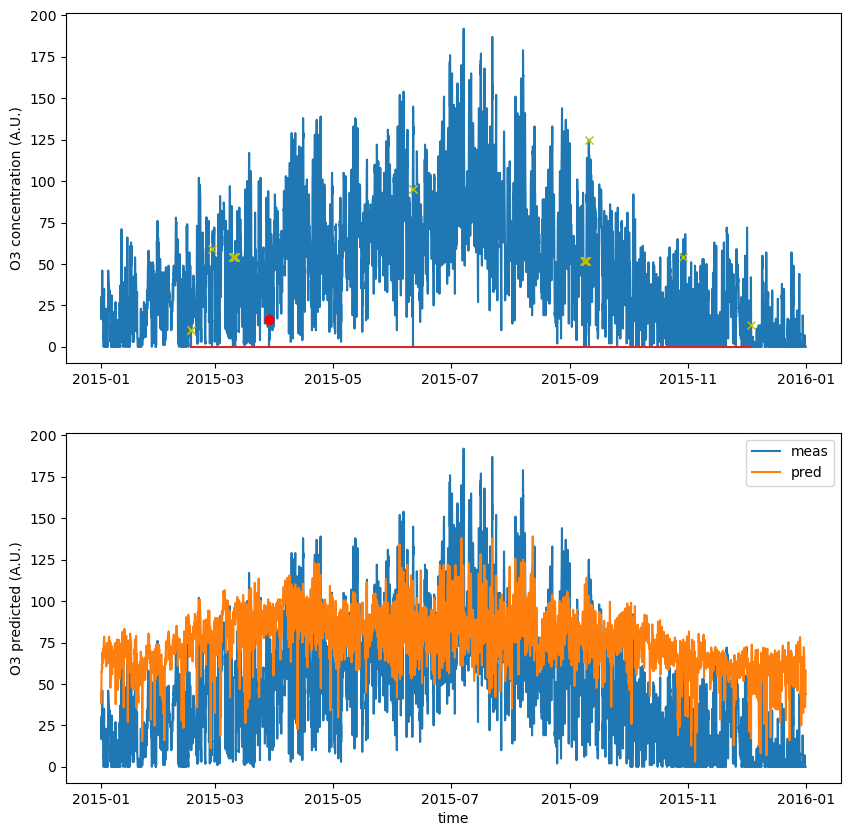

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

plt.subplots(2,1,figsize=(10,10) )
plt.subplot(2,1,1)

plt.plot(y_station)
plt.stem(y_station.index[T_index_pb],y_station.iloc[T_index_pb],\
         markerfmt='ro')
plt.stem(y_station.index[NA_ind],np.asarray(y_station)[NA_ind],\
         markerfmt='xy')

plt.ylabel('O3 concentration (A.U.)')

plt.subplot(2,1,2)
plt.plot(y_station,label='meas')
plt.plot(sel_id_chimere['val'],label='pred')
plt.xlabel('time')
plt.ylabel('O3 predicted (A.U.)')
plt.legend()
plt.show()
plt.tight_layout()

## Gather Data in a matrix 


### Option 1 : Include as predictors ALL the past hours for a given depth of history

#### Set the forecasting problem parameters

In [19]:
nsample = len(y_station)

# Take past value at time H-history
num_days = 7 # number of days
history = num_days*24 + 1 # D days of hourly measures (from day D, hour H to day D-7 hour H included)
# note that $history-1$ is now the offset index to get CURRENT time instant!

# Predict at time H+forecast
forecast = 24 # 24 h = 1 day ahead forecasting

#### Reshape the data

In [20]:
# Take concentration at time H+forecast 
ya_target = y_station[history+forecast-1:]

# Take chimere simulation at time H  (+ possibly past values)
xa_chimere = sel_id_chimere['val'][history-1:nsample-forecast]

# Take past concentration values
Xa = np.zeros( shape=(nsample-forecast-history+1, history) ) 
for h in range(nsample-forecast-history+1):
    # Take past values
    Xa[h,:] = y_station[h:h+history]    

# Flip the predictor variables to get the current value as first column
Xa = np.fliplr(Xa)  
    
# Add current chimere simu as a feature (cat at the last column of X)
Xa = np.concatenate( (Xa, xa_chimere.to_numpy().reshape(-1, 1) ) ,axis = 1  )

print(Xa.shape)
ya_target.shape

(8568, 170)


(8568,)

In [21]:
# Check that the X,y data are correctly time registered
print('starting time')
print('{} (xa_chimere)'.format(xa_chimere.index[0]))
print('{} (current predictor X)'.format(y_station[0:0+history].index[-1]))
print('{} (last predictor X)'.format(y_station[0:0+history].index[0]))
print('{} (target y)'.format(ya_target.index[0]))

print('ending time')
print('{} (xa_chimere)'.format(xa_chimere.index[-1]))
print('{} (current predictor X)'.format(
    y_station[(nsample-forecast-history):(nsample-forecast-history)+history].index[-1]))
print('{} (last predictor X)'.format(
    y_station[(nsample-forecast-history):(nsample-forecast-history)+history].index[0]))
print('{} (target y)'.format(ya_target.index[-1]))

starting time
2015-01-08 00:00:00+00:00 (xa_chimere)
2015-01-08 00:00:00+00:00 (current predictor X)
2015-01-01 00:00:00+00:00 (last predictor X)
2015-01-09 00:00:00+00:00 (target y)
ending time
2015-12-30 23:00:00+00:00 (xa_chimere)
2015-12-30 23:00:00+00:00 (current predictor X)
2015-12-23 23:00:00+00:00 (last predictor X)
2015-12-31 23:00:00+00:00 (target y)


### Option 2:  Include ONLY the *daily* past values at the *same* hour than the target

In [22]:
nsample = len(y_station)

# Take past value at time $D - history$ (in days)
history = 7 # one week of measure (in days)
# note that $history*24-1$ is now the offset index to get current time instant!

# Predict at time D+forecast (in day)
forecast = 1 # one day

offset = forecast*24+ (history-1)*24 # in samples (hours)

# Take concentration at time H+forecast 
yh_target = y_station[offset:]

# Take chimere simulation at time H  (+ possibly past values)
xh_chimere = sel_id_chimere['val'][(history-1)*24:nsample-forecast*24]

# Take past concentration values per day (same hour)
Xh = np.zeros( shape=(nsample-offset,history) ) # past values 
for h in range(nsample-offset):
    # Take past values
    Xh[h,:] = y_station[h:h+history*24:24]

# Flip the predictor variables to get the current value as first column
Xh = np.fliplr(Xh)
    
# Add current chimere simu as a feature (cat at the last column of X)
Xh = np.concatenate( (Xh, xh_chimere.to_numpy().reshape(-1, 1) ) ,axis = 1  )

Xh.shape

(8592, 8)

In [23]:
# Check that the X,y data are correctly registered
print('starting time')
print('{} (x_temp)'.format(xh_chimere.index[0]))
print('{} (current predictor X)'.format(y_station[0:0+history*24:24].index[-1]))
print('{} (last predictor X)'.format(y_station[0:0+history*24:24].index[0]))
print('{} (target y)'.format(yh_target.index[0]))

print('ending time')
print('{} (x_temp)'.format(xh_chimere.index[-1]))
print('{} (current predictor X)'.format(
    y_station[(nsample-offset-1):(nsample-offset-1)+history*24:24].index[-1]))
print('{} (last predictor X)'.format(
    y_station[(nsample-offset-1):(nsample-offset-1)+history*24:24].index[0]))
print('{} (target y)'.format(yh_target.index[-1]))

starting time
2015-01-07 00:00:00+00:00 (x_temp)
2015-01-07 00:00:00+00:00 (current predictor X)
2015-01-01 00:00:00+00:00 (last predictor X)
2015-01-08 00:00:00+00:00 (target y)
ending time
2015-12-30 23:00:00+00:00 (x_temp)
2015-12-30 23:00:00+00:00 (current predictor X)
2015-12-24 23:00:00+00:00 (last predictor X)
2015-12-31 23:00:00+00:00 (target y)


### Option 3:  Include ONLY a fixed day of the week, say Thursday, as target 

The columns of the matrix are [Wednesday,Tuesday,Monday,Chimere_pred Thursday] hourly data

In [24]:
import datetime
datetime.datetime.today().weekday()
# check the day index of today :
# Monday is 0
# Tuesday is 1 ... and so on until 6 which is Sunday
# Thursday has index 3. 
todayname = datetime.datetime.today().strftime("%A")
weekdaynumber = datetime.datetime.today().weekday()
print('today ({}) is day number {}'.format(todayname,weekdaynumber))

today (Tuesday) is day number 1


In [25]:
# Get all the thursday (weekday number 3) hourly samples
iweekday = np.where(ya_target.index.weekday.to_numpy() == 3 )[0]
yd_target = ya_target.iloc[iweekday]
yd_target.shape
num_days = 3 # number of days
history = num_days*24 + 1 # D days of hourly measures (from day D, hour H to day D-7 hour H included)
Xd = Xa[iweekday,:history]
# Add chimere thusday prediction as a feature (cat at the last column of X)
Xd = np.concatenate( (Xd, xa_chimere.iloc[iweekday].to_numpy().reshape(-1, 1) ) ,axis = 1  )


In [26]:
# Get all the thursday (weekday number 3) hourly samples
iweekday = np.where(ya_target.index.weekday.to_numpy() == 3 )[0]
yd_target = ya_target.iloc[iweekday]
yd_target.shape

# Reduce the history to the last three days ()
num_days = 3 # number of days
history = num_days*24 + 1 # D days of hourly measures (from day D, hour H to day D-7 hour H included)
Xd = Xa[iweekday,:history]

# Add chimere thusday prediction as a feature (cat at the last column of X)
Xd = np.concatenate( (Xd, xa_chimere.iloc[iweekday].to_numpy().reshape(-1, 1) ) ,axis = 1  )

# Check that the X,y data are correctly registered
print('starting time')
print('{} (target y)'.format(yd_target.index[0]))
print('ending time')
print('{} (target y)'.format(yd_target.index[-1]))
print('\n\n10 first thursdays to predict')
print(yd_target.index[0:10*24:24].to_numpy())

Xd.shape

starting time
2015-01-15 00:00:00+00:00 (target y)
ending time
2015-12-31 23:00:00+00:00 (target y)


10 first thursdays to predict
[Timestamp('2015-01-15 00:00:00+0000', tz='UTC')
 Timestamp('2015-01-22 00:00:00+0000', tz='UTC')
 Timestamp('2015-01-29 00:00:00+0000', tz='UTC')
 Timestamp('2015-02-05 00:00:00+0000', tz='UTC')
 Timestamp('2015-02-12 00:00:00+0000', tz='UTC')
 Timestamp('2015-02-19 00:00:00+0000', tz='UTC')
 Timestamp('2015-02-26 00:00:00+0000', tz='UTC')
 Timestamp('2015-03-05 00:00:00+0000', tz='UTC')
 Timestamp('2015-03-12 00:00:00+0000', tz='UTC')
 Timestamp('2015-03-19 00:00:00+0000', tz='UTC')]


(1224, 74)

### Option 4: mix different strategies as you want!
....

## Apply machine learning tools to forecast 

### Preprocess the data (continuated) : scaling

In [27]:
from sklearn.preprocessing import StandardScaler

# Scale (standardize) the data
sc = StandardScaler()
Xa_s= sc.fit_transform(Xa)
Xh_s= sc.fit_transform(Xh)

### Nearest neighbors regression

In [28]:
from sklearn.neighbors import KNeighborsRegressor

# D+1 forecasting with daily measurements from one week backward
X = Xh_s
y = yh_target

# always the same code ('fit' and 'predict'), whatever the method/model 
nn_h = KNeighborsRegressor(n_neighbors=51)
nn_h.fit(X, y)
y_nn_h = nn_h.predict(X)

### Display forecast

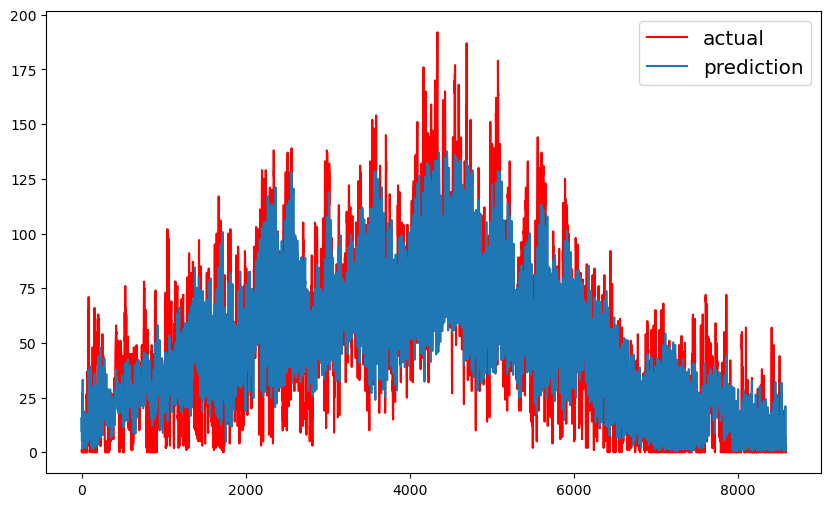

In [29]:
plt.figure(figsize=(10,6))
plt.plot(yh_target.values,'r')
plt.plot(y_nn_h)
plt.legend(['actual','prediction'], fontsize="x-large")
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# note that we can introduce weights to mitigate/remove extreme value
r2_train = r2_score(y,y_nn_h)
mad_train = median_absolute_error(y_nn_h,y)
print('training error r2 = {}, MAD = {}'.format(r2_train,mad_train) )

training error r2 = 0.7503328130922853, MAD = 11.196078431372552


### Cross-validate the parameters

In [31]:
# Create KGroupFold split with one group per year (for instance)
# Better than default KFold cross-validation that will randomly 
# split contiguous time instants (thus very correlated  values) 
# in train and test groups

from sklearn.model_selection import LeaveOneGroupOut

groups = np.zeros( y.shape)
months = y.index.month.to_numpy()
for iy , month in enumerate(np.arange( months.min(),  months.max()+1 )):
    gindex = np.where( months == month)[0]
    groups[gindex] = iy

cv = LeaveOneGroupOut()
ngroups = cv.get_n_splits(X, y, groups)
g_splitter = cv.split(X,y, groups)
#for train_index, test_index in g_splitter:
#    print("TRAIN:", train_index, "TEST:", test_index)

In [32]:
# CV Estimation of the best hyperparameters (can take a while...)
# Tips:
# - better to avoid high number of features/variables for knn
# - possibly, you can use a 'jupyter-hub' or 'google colab' services ro run your notebook 
#   if you need extra memory or cpu/gpu time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import median_absolute_error

metrics       = ['euclidean','manhattan']
#metrics       = ['manhattan']
numNeighbors  = np.arange(1,300,10)
param_grid    = dict(metric=metrics,n_neighbors=numNeighbors)
scoring = {'r2': 'r2', 'MAD': 'neg_median_absolute_error'}
grid = GridSearchCV(KNeighborsRegressor(),param_grid=param_grid, 
                   cv=cv.split(X,y, groups), #iid=False,
                   scoring = scoring , refit='MAD',
                   n_jobs=-1)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)

{'metric': 'manhattan', 'n_neighbors': 121}
-12.633264462809917


{'metric': 'manhattan', 'n_neighbors': 121}
-12.633264462809917


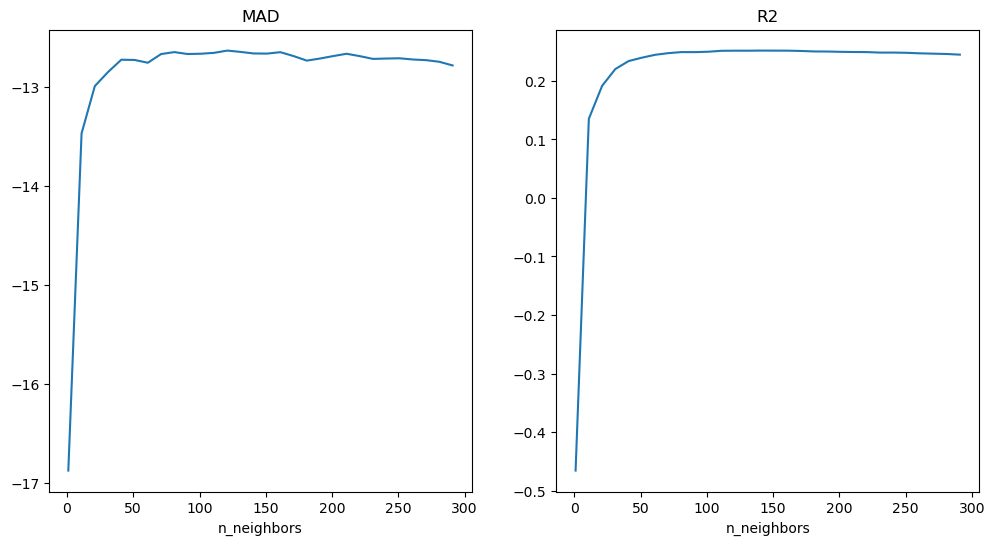

In [33]:
# display CV results
results = grid.cv_results_
print(grid.best_params_)
print(grid.best_score_)

plt.figure(figsize=(12,6))
plt.subplot(121)
iman = results['param_metric'].data=='manhattan'
plt.plot(results['param_n_neighbors'][iman].data , results['mean_test_MAD'][iman])
plt.xlabel('n_neighbors')
plt.title('MAD')
plt.subplot(122)
plt.plot(results['param_n_neighbors'][iman].data , results['mean_test_r2'][iman])
plt.xlabel('n_neighbors')
plt.title('R2')
plt.show()

Observe that the optimal number of neighbors is quite high. This emphasizes that the concentration
time series have a high random variability, which requires a fairly large regularization (averaging over a large neighborhood) in order to improve the accuracy on new data

### Random Forest Regression

In [34]:
from sklearn.ensemble import RandomForestRegressor

# D+1 forecasting with full hourly measurements from one week backward
X = Xa_s
y = ya_target

max_depth = 20
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=0, oob_score=True,
                                verbose=1,
                                criterion='squared_error', # Rk: too time consuming with the more robust 'mae'
                                n_jobs=-1)
regr_rf.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished


RandomForestRegressor(max_depth=20, n_jobs=-1, oob_score=True, random_state=0,
                      verbose=1)

In [35]:
y_rf_a= regr_rf.predict(X)
r2_train = r2_score(y,y_rf_a)
mad_train = median_absolute_error(y_rf_a,y)
print('training error r2 = {}, MAD = {}'.format(r2_train,mad_train) )
print('out of bag score (r2 estimaeted on non used data)= {}'.format(regr_rf.oob_score_))

training error r2 = 0.9766843074551301, MAD = 3.4067715295258623
out of bag score (r2 estimaeted on non used data)= 0.8351034602598456


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


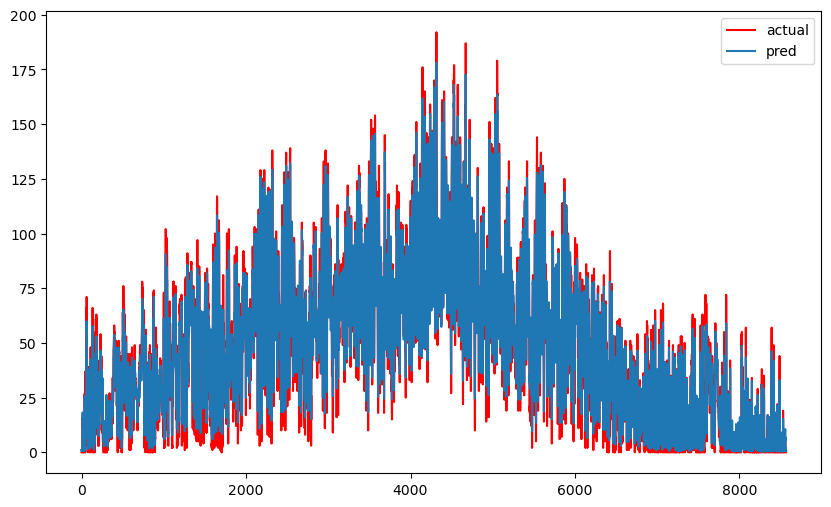

In [36]:
plt.figure(figsize=(10,6))
plt.plot(ya_target.values,'r')
plt.plot(y_rf_a)
plt.legend(['actual','pred'])
plt.show()

**RF gives for free a *score of how the feature* is important**, or **significant**, for the RF regressor
(e.g., from each feature how many times it is used in the decision trees, and how it decreases the variance of the prediction error), 

May be useful to reduce the dimension (variable selection to decrease the number number of features) and to improve the generalization ability

([<matplotlib.axis.XTick at 0x322936150>,
 [Text(0, 0, 'D0'),
  Text(24, 0, 'D-1'),
  Text(48, 0, 'D-2'),
  Text(72, 0, 'D-3'),
  Text(96, 0, 'D-4'),
  Text(120, 0, 'D-5'),
  Text(144, 0, 'D-6'),
  Text(168, 0, 'Chimere')])

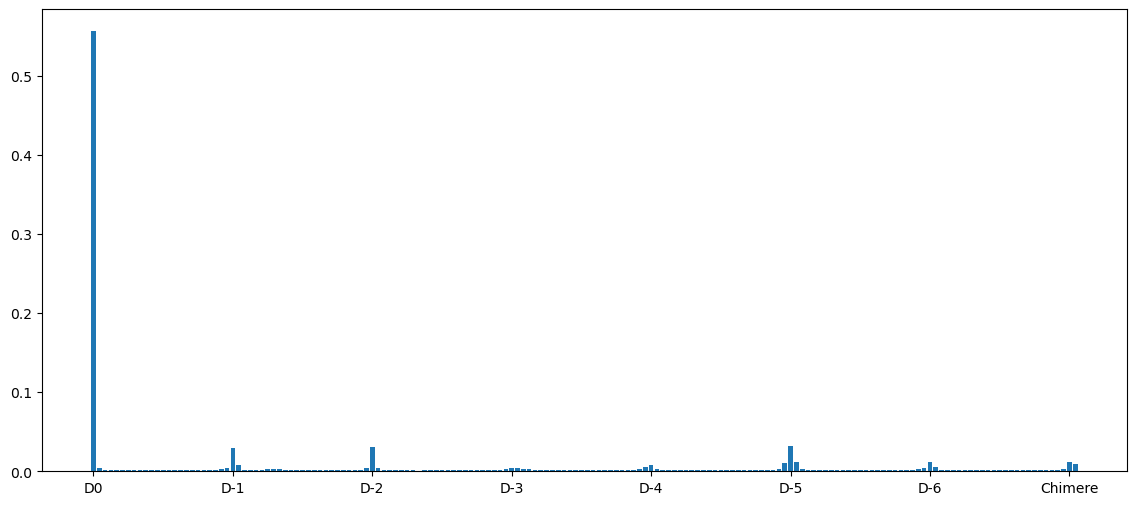

In [37]:
plt.figure(figsize=(14,6))
plt.bar(np.arange(len(regr_rf.feature_importances_)), regr_rf.feature_importances_)
plt.xticks(np.arange(0,24*7+1,24),labels=['D0','D-1','D-2','D-3','D-4','D-5','D-6','Chimere'] )

Observe that for the **D+1** forecast, the most important RF features based on the complete hourly measurements of the past week plus (D+1) chimere prediction (last predictor) are in order:
1. concentration at the same time **one day backward** (daily component)
2. concentration at the same time several days backward (harmonics of the daily components)
3. Chimere simulation

#### Estimate (CV) the test scores for RF

In [38]:
from sklearn.model_selection import cross_validate

groups = np.zeros( y.shape)
months = y.index.month.to_numpy()
for iy , month in enumerate(np.arange( months.min(),  months.max()+1 )):
    gindex = np.where( months == month)[0]
    groups[gindex] = iy

cv = LeaveOneGroupOut()
ngroups = cv.get_n_splits(X, y, groups)
g_splitter = cv.split(X,y, groups)
scoring = {'r2': 'r2', 'MAD': 'neg_median_absolute_error'}
scores = cross_validate(regr_rf, X, y, cv=cv.split(X,y, groups),
                        scoring = scoring)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.6s
[Parallel(n

In [39]:
mad_test = np.mean(scores['test_MAD'])
r2_test = np.mean(scores['test_r2'])        
print('test error r2 = {}, MAD = {}'.format(r2_test,mad_test) )
print('out of bag score (r2 estimated on non used data)= {}'.format(regr_rf.oob_score_))

test error r2 = 0.21933439863090912, MAD = -13.198432261982402
out of bag score (r2 estimated on non used data)= 0.8351034602598456


observe here that these test error scores are slightly worse than knn with daily predictors